<a href="https://colab.research.google.com/github/yusufdalva/ML_implementations/blob/master/PyTorch_fundamentals/FashionMNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Class Classification with Simple CNNs
In this part of the tutorial, we are going to go over the simple training pipeline of PyTorch. As a task, we will train a classifier to perform a 10-class image classification.

## Importing PyTorch
To implement our model, we will use some modules provided by PyTorch. The necessary imports are given in the cell below.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import datasets, transforms

## Checking Which Version Are We Using
To check the installation version of PyTorch in our current system, we can use $\texttt{torch.__version__()}$. Here, *1.10.0* denotes the PyTorch version and *cu111* denotes the version of CUDA Toolkit installed (11.1 here). CUDA toolkit enables us to communicate with NVIDIA GPUs to accelerate our implementation.

In [ ]:
print("Using Pytorch {}".format(torch.__version__))

Using Pytorch 1.10.0+cu111


## GPU Related Information
To be sure that we can accelerate our implementation with a GPU in the current setup, we can check the GPU details as follows. In Colab, you can get GPU support in a limited amount. See Runtime->Change Runtime Type to utilize GPU in your run.

In [ ]:
is_gpu_available = torch.cuda.is_available()
print("Is GPU being used: {}".format(is_gpu_available))
if is_gpu_available:
    print("There are {} GPU(s) available".format(torch.cuda.device_count()))
    device_id = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(device_id)
    print("Name of the current GPU: {}".format(device_name))

Is GPU being used: True
There are 1 GPU(s) available
Name of the current GPU: Tesla T4


In [ ]:
!nvidia-smi

Sun Apr  3 19:46:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading the Dataset
We will use the Fashion-MNIST dataset for training. $\texttt{torchvision}$ library provides some datasets that are already splitted to train and test sets, where Fashion-MNIST is one of them. So we will download the dataset and load it apprpriately.

To load the data in batches, we will use DataLoader class from PyTorch. This converts our data to tensors and loads them as batches.

In [ ]:
transform_data = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # The images are grayscale, we only normalize one channel

train_dataset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform_data)
train_data_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform_data)
test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=True) # Batch size is different just to show that it can be loaded differently

## Model Definition
Now we will decribe out model, with implemented modules in PyTorch. We will use 2 consecutive convolution blocks, followed by three dense layers (Linear). Here, keep in mind that the output size is determined by the following formula for a given convolutional layer:<br><br>
$width\_out = \frac{width - kernel\_size + 2 \times padding}{stride}$<br> <br>$height\_out = \frac{height - kernel\_size + 2 \times padding}{stride}$

### What does Conv2d define
When we define a $\texttt{nn.Conv2d}$ layer with in_channels = i and out_channels = o, we define o different filters where each of them is i dimensional. So if I define 3x3 filters with kernel size 3, each of my filters are ix3x3 and I have o of them.<br>

![alt text](https://media5.datahacker.rs/2018/11/new_NN_CNN_1_1.png "2D Convolution example")

In [ ]:
class FMNIST_Classifier(nn.Module):
    def __init__(self, conv_channels):
        super(FMNIST_Classifier, self).__init__()

        assert len(conv_channels) == 2 # I will have 2 consecutive convultional blocks
        self.conv_channels = conv_channels

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.conv_channels[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(self.conv_channels[0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=self.conv_channels[0], out_channels=self.conv_channels[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(self.conv_channels[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        output_size = (28 // 4) # Downsampled it 2 times
        self.fc_1 = nn.Linear(in_features=self.conv_channels[1] * output_size * output_size, out_features=128)
        self.fc_2 = nn.Linear(in_features=128, out_features=64)
        self.fc_3 = nn.Linear(in_features=64, out_features=10) # Predicting probabilities for 10 class

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = x.view(-1, self.conv_channels[1] * 7 * 7) # Flatten the tensor
        x = self.fc_1(x)
        x = self.fc_2(x)
        x = self.fc_3(x)
        return x


## Definining the Optimization Function
For our model, we use Cross Entropy Loss for multiple classes. $\texttt{nn.CrossEntropyLoss}$ provides a loss operating on Log(Softmax) values, where softmax function is the multi-class case of the sigmoid function. The formulation of Cross Entropy Loss is as follows:<br>
$\LARGE{\mathcal{L} = - \sum_{c=1}^{C} log \frac{exp({o_{n,c}})}{\sum_{i=1}^C exp(o_{n,i})}}
$ <br>
Here, $\frac{exp({o_{n,c}})}{\sum_{i=1}^C exp(o_{n,i})}$ is the softmax function. C denotes the number of classes. In this function we simply try to calculate a probability by the regressed values for 10 different classes.
<br>
Note that we need to pass every module or variable we need to GPU, to use ahrdware acceleration. We can do this with call $\texttt{.cuda()}$.

In [ ]:
criterion = nn.CrossEntropyLoss()
conv_channels = [32, 64]
model = FMNIST_Classifier(conv_channels)
if is_gpu_available:
    model.cuda()

## Defining the optimizer
To update my weights, I need a gradient update algorithm. For our prouposes, we selected Stochastic Gradient Descent as the simplest update mechanism. Keep in mind that even though the name says **Stochastic**, we can iterate it in a full-batch or mini-batch manner. This algorithm updates the weights bu scaling the gradients with the $\texttt{learning_rate}$ you provided. 


If you take a look at the update algoritms in $\texttt{torch.optim}$, SGD is the vanilla version among different optimizers.

In [ ]:
learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## Training the model
To train our model, we need to go though several steps. In training we will go through data batches in every epoch. In every iterarion (every batch) we will do the following steps:<br>
- Reset the gradient: Be sure that gradients from the previous updates are cleared ($\texttt{optimizer.zero_grad()}$)
- Perform Predcitions: We need to perform predictions ($\texttt{model(x)}$) to calculate the loss and to be able to calculate the respective gradients. Then we calculate the loss from predictions
- Calculate the gradients: When performing the gradients, we loaded the values needed to calculate the gradients. If we call a backpropogation, gradients will be calculated ($\texttt{loss.backward()}$)
- Updating the weights: Now that we have the gradients, we will update the weights by calling $\texttt{optimizer.step()}$

In [ ]:
from tqdm import tqdm
# Training loop
no_of_epochs = 20
iter_losses = []
epoch_losses = []
for epoch in range(no_of_epochs):
    running_loss = 0.0
    print("Epoch: {}/{}".format(epoch + 1, no_of_epochs))
    for batch_data, batch_labels in tqdm(train_data_loader):
        optimizer.zero_grad() # Setting the starting gradients as 0
        batch_outputs = model(batch_data.cuda()) # Predict outputs
        loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) # Calculate the loss
        loss.backward() # Calculate the gradients
        optimizer.step() # Update the weights
        iter_losses.append(loss.item())
        running_loss += loss.item()
    epoch_losses.append(running_loss / len(train_data_loader))
    print("Loss for epoch: {}".format(running_loss / len(train_data_loader)))
print("Finished Training!")


Epoch: 1/20


100%|██████████| 469/469 [00:15<00:00, 29.50it/s]


Loss for epoch: 1.4819651057979446
Epoch: 2/20


100%|██████████| 469/469 [00:12<00:00, 36.95it/s]


Loss for epoch: 0.8227935920137841
Epoch: 3/20


100%|██████████| 469/469 [00:12<00:00, 36.55it/s]


Loss for epoch: 0.6535154732305613
Epoch: 4/20


100%|██████████| 469/469 [00:12<00:00, 37.67it/s]


Loss for epoch: 0.5775531139582205
Epoch: 5/20


100%|██████████| 469/469 [00:13<00:00, 35.95it/s]


Loss for epoch: 0.5311321586942368
Epoch: 6/20


100%|██████████| 469/469 [00:12<00:00, 37.38it/s]


Loss for epoch: 0.49759504974269664
Epoch: 7/20


100%|██████████| 469/469 [00:12<00:00, 37.38it/s]


Loss for epoch: 0.4718249667046675
Epoch: 8/20


100%|██████████| 469/469 [00:12<00:00, 36.81it/s]


Loss for epoch: 0.4506104321622137
Epoch: 9/20


100%|██████████| 469/469 [00:12<00:00, 37.68it/s]


Loss for epoch: 0.4332285194254633
Epoch: 10/20


100%|██████████| 469/469 [00:12<00:00, 37.62it/s]


Loss for epoch: 0.418554499427647
Epoch: 11/20


100%|██████████| 469/469 [00:12<00:00, 37.33it/s]


Loss for epoch: 0.405614657760429
Epoch: 12/20


100%|██████████| 469/469 [00:12<00:00, 37.13it/s]


Loss for epoch: 0.39438137230969694
Epoch: 13/20


100%|██████████| 469/469 [00:12<00:00, 37.04it/s]


Loss for epoch: 0.38405517706357595
Epoch: 14/20


100%|██████████| 469/469 [00:12<00:00, 37.61it/s]


Loss for epoch: 0.37493668496608734
Epoch: 15/20


100%|██████████| 469/469 [00:12<00:00, 37.56it/s]


Loss for epoch: 0.36678513598594586
Epoch: 16/20


100%|██████████| 469/469 [00:12<00:00, 37.36it/s]


Loss for epoch: 0.3592687346406583
Epoch: 17/20


100%|██████████| 469/469 [00:12<00:00, 37.88it/s]


Loss for epoch: 0.3520320958610791
Epoch: 18/20


100%|██████████| 469/469 [00:12<00:00, 37.37it/s]


Loss for epoch: 0.3455146059616288
Epoch: 19/20


100%|██████████| 469/469 [00:12<00:00, 37.43it/s]


Loss for epoch: 0.33925979570158
Epoch: 20/20


100%|██████████| 469/469 [00:12<00:00, 37.05it/s]

Loss for epoch: 0.33392963235947626
Finished Training!


## Evaluation
After training the model, now we can have a look at the correct predictions by looking at the test set. As we loaded the data with a dataloader, we will iterate through batches. Keep in mind that some layers behave differently in test time and training time. So, taking the model to eval mode is a good practice. Following the predictions, we calculate the confusion matrix for our predictions.

In [ ]:
model.eval()
correct_preds = 0
total_preds = 0
all_preds = torch.tensor([])
all_labels = torch.tensor([])
with torch.no_grad():
    for batch_data, batch_labels in test_data_loader:
        batch_data = batch_data.cuda()
        batch_labels = batch_labels.cuda()
        batch_outputs = model(batch_data)
        # Max returns: (max_values, max_indices)
        # We only need the indices to assess the predictions
        _, pred_labels = torch.max(batch_outputs, dim=1)
        total_preds += pred_labels.size(0)
        correct_preds += (pred_labels == batch_labels).sum().item()
        all_preds = torch.cat((all_preds, pred_labels.cpu()), dim=0)
        all_labels = torch.cat((all_labels, batch_labels.cpu()), dim=0)
    print("Accuracy: {}".format(correct_preds / total_preds))

Accuracy: 0.8721


In [ ]:
confusion_matrix = torch.zeros(10, 10, dtype=torch.int64)
for label_idx in range(len(all_labels)):
    predicted = all_preds[label_idx].int()
    real = all_labels[label_idx].int()
    confusion_matrix[real, predicted] += 1

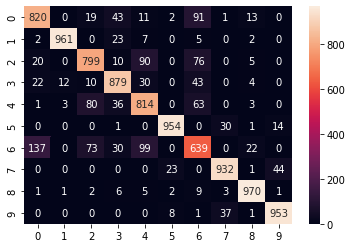

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
ax = sns.heatmap(confusion_matrix.numpy(), annot=True, fmt="d")
fig.show()

## How does the Loss Change?
As we optimize our optimization function, we expect that our loss value goes down, as we go in the direction in the optimal direction. Note how the loss values flunctuate when we take a look at the loss at every update. This shows the nature of gradient descent and how it searches for the optimal point for the model weights.

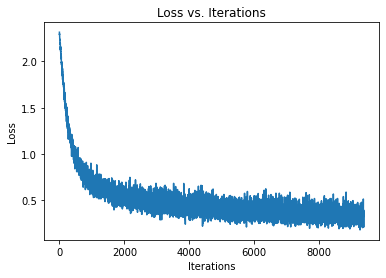

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(len(iter_losses)), iter_losses)
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.set_title("Loss vs. Iterations")
fig.show()

When we average the loss values for every epoch, we can see the decreasing nature of the loss function clearly. Note that these are not the actual loss values, but the loss values averaged over an epoch.

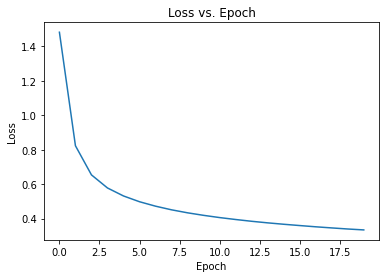

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_losses)), epoch_losses)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss vs. Epoch")
fig.show()